<a href="https://colab.research.google.com/github/remre/striveschool/blob/main/ChineseMnistCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd 
import torch
from torch import optim
import torch.nn as nn

import cv2
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as a_s
import os 
from torchsummary import summary
import zipfile

In [ ]:
#get kaggle.json 

os.environ["KAGGLE_CONFIG_DIR"] = ("/content")

In [ ]:
#than download the dataset
!kaggle datasets download -d gpreda/chinese-mnist

 30% 5.00M/16.5M [00:00<00:00, 48.0MB/s]
100% 16.5M/16.5M [00:00<00:00, 87.6MB/s]


In [ ]:
#unzip the dataset

with zipfile.ZipFile('/content/chinese-mnist.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
#crate the dataframe
df = pd.read_csv('chinese_mnist.csv',sep=',')

In [ ]:
#y = df['character']

In [ ]:
df.sample(n=7)
# df
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   15000 non-null  int64 
 1   sample_id  15000 non-null  int64 
 2   code       15000 non-null  int64 
 3   value      15000 non-null  int64 
 4   character  15000 non-null  object
dtypes: int64(4), object(1)
memory usage: 586.1+ KB


(15000, 5)

In [ ]:
df.drop('character', axis=1)

,suite_id,sample_id,code,value,class_id
0,1,1,10,9,9
1,1,10,10,9,9
2,1,2,10,9,9
3,1,3,10,9,9
4,1,4,10,9,9
...,...,...,...,...,...
14995,99,5,9,8,8
14996,99,6,9,8,8
14997,99,7,9,8,8
14998,99,8,9,8,8


In [ ]:
df

,suite_id,sample_id,code,value,character,class_id
0,1,1,10,9,九,9
1,1,10,10,9,九,9
2,1,2,10,9,九,9
3,1,3,10,9,九,9
4,1,4,10,9,九,9
...,...,...,...,...,...,...
14995,99,5,9,8,八,8
14996,99,6,9,8,八,8
14997,99,7,9,8,八,8
14998,99,8,9,8,八,8


In [ ]:
#take a look at it
df# image file names include some info about the image like suite_id sample id and code.
#if we can add value as a label for our custom dataset that will be good.

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九
...,...,...,...,...,...
14995,99,5,9,8,八
14996,99,6,9,8,八
14997,99,7,9,8,八
14998,99,8,9,8,八


In [ ]:
df.isnull().sum(),df.shape #there is no missing vals and number of data and number of images are match up

(suite_id     0
 sample_id    0
 code         0
 value        0
 character    0
 dtype: int64, (15000, 5))

In [ ]:
df.info()#we need to encode df character. we can use get dummies 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   15000 non-null  int64 
 1   sample_id  15000 non-null  int64 
 2   code       15000 non-null  int64 
 3   value      15000 non-null  int64 
 4   character  15000 non-null  object
 5   class_id   15000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 703.2+ KB


In [ ]:
X = df.drop('character', axis=1)

In [ ]:
# character_dictionary = {'零':int(0),'一':int(1),'二':int(2),'三':int(3),'四':int(4),'五':int(5),'六':int(6),'七':int(7),'八':int(8),'九':int(9),'十':int(10),'百':int(11),'千':int(12),'万':int(13),'亿':int(14)}
# inv_character_dictionary = {v: k for k, v in character_dictionary.items()}

# class_ids = []
# for index, row in df.iterrows():
#     class_ids.append(character_dictionary[row['character']])
# df["class_id"] = class_ids

In [ ]:
# df = df.drop('class_id', axis=1)

In [ ]:
df

,suite_id,sample_id,code,value,character
2449,49,9,12,100,百
5962,96,2,15,100000000,亿
12793,80,3,7,6,六
2684,70,4,12,100,百
12257,31,7,7,6,六
...,...,...,...,...,...
8460,50,1,3,2,二
244,30,4,10,9,九
14315,37,5,9,8,八
10014,10,4,5,4,四


In [ ]:
k = np.asarray(df.iloc[:, 4])
target = 'character'
y = df[target]

In [ ]:
y.shape

(15000,)

In [ ]:
k.shape

(15000,)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, k,l, csv_file ='../content/chinese_mnist.csv'):


    self.df = pd.read_csv(csv_file)
    

    self.chr= {'九':int(9),'十':int(10),'百':int(11),'千':int(12),'万':int(13),'亿':int(14),'零':int(0),'一':int(1),'二':int(2),'三':int(3),'四':int(4),'五':int(5),'六':int(6),'七':int(7),'八':int(8)}

    


    self.target = 'character'

    # self.features = ['suite_id','sample_id','code',]
    #self.categorical = 'value'

    #self.cat = pd.get_dummies(df, prefix=self.categorical)

    # self.labels   = np.asarray(self.df.iloc[:, 4])
    
    self.y = df[self.target]
    self.X = df.drop(self.target, axis =1 )

  def __getitem__(self,idx):

    single_image_label = self.y[idx]

    class_id = self.chr[single_image_label]
    
    img = Image.open(f"../content/data/data/input_{self.X.iloc[idx, 0]}_{self.X.iloc[idx, 1]}_{self.X.iloc[idx, 2]}.jpg")
    img = np.array(img) # convert to np.array
       

    return img, class_id

  def __len__(self):

    return len(self.X)


In [ ]:
# split data 70% of train 30% as test data
train_df = df.groupby('value').apply(lambda x: x.sample(700, random_state=42)).reset_index(drop=True)
x_train, y_train  = train_df.iloc[:, :-2], train_df.iloc[:, -2]

test_df  = df.groupby('value').apply(lambda x: x.sample(300, random_state=42)).reset_index(drop=True)
x_test, y_test    = test_df.iloc[:, :-2], test_df.iloc[:, -2]

In [ ]:
y_test

0               0
1               0
2               0
3               0
4               0
          ...    
4495    100000000
4496    100000000
4497    100000000
4498    100000000
4499    100000000
Name: value, Length: 4500, dtype: int64

In [ ]:
#create train dataset and test dataset 
train_ds = CustomDataset(x_train, y_train)
trainloader = DataLoader(dataset=train_ds,batch_size=32, shuffle=True)

In [ ]:
test_ds = CustomDataset(x_test, y_test)
testloader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [ ]:
train_ds

In [ ]:
dictt = {int(9):'九',int(10):'十',int(11):'百',
  int(12):'千',int(13):'万',int(14):'亿',
  int(0):'零',int(1):'一',int(2):'二',
  int(3):'三',int(4):'四',int(5):'五',
  int(6):'六',int(7):'七',int(8):'八'}

tensor(7) 七


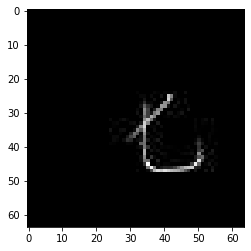

In [ ]:
dataiter = iter(testloader)
images,labels = dataiter.next()
plt.imshow(images[0], cmap='gray')#


print(labels[0],dictt[int(labels[0])])
# dictt['零']

In [ ]:
#images[0].shape

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        
        self.fc1 = nn.Linear(64*13*13, 500)
        self.fc2 = nn.Linear(500, 15)

        self.log_softmax = nn.LogSoftmax(dim=0)
        self.conv2_drop = nn.Dropout2d()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        output = self.log_softmax(x)
        return output

model = Net()
            

In [ ]:
#summary(model,(64,64))

In [ ]:
los = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001,)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
#optimizer = optim.SGD(model.parameters(),lr = 0.001,momentum=1)

In [35]:
epochs = 5
#learning_rate = 0.001
#decay_rate = learning_rate / epochs
#optimizer = optim.Adagrad(model.parameters(),lr = learning_rate)
print_every = 96

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # turn it to float and resize
        
        images = images.resize_(images.size()[0], 64,64).float()
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        losss = los(output, labels)     # 2) Compute loss
        losss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += losss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/len(trainloader):.3f}")
            running_loss = 0

Epoch: 1/5
	Iteration: 0	 Loss: 0.008
	Iteration: 96	 Loss: 0.430
	Iteration: 192	 Loss: 0.261
	Iteration: 288	 Loss: 0.194
	Iteration: 384	 Loss: 0.158
Epoch: 2/5
	Iteration: 0	 Loss: 0.001
	Iteration: 96	 Loss: 0.120
	Iteration: 192	 Loss: 0.121
	Iteration: 288	 Loss: 0.111
	Iteration: 384	 Loss: 0.102
Epoch: 3/5
	Iteration: 0	 Loss: 0.001
	Iteration: 96	 Loss: 0.083
	Iteration: 192	 Loss: 0.086
	Iteration: 288	 Loss: 0.089
	Iteration: 384	 Loss: 0.085
Epoch: 4/5
	Iteration: 0	 Loss: 0.001
	Iteration: 96	 Loss: 0.075
	Iteration: 192	 Loss: 0.071
	Iteration: 288	 Loss: 0.071
	Iteration: 384	 Loss: 0.078
Epoch: 5/5
	Iteration: 0	 Loss: 0.000
	Iteration: 96	 Loss: 0.065
	Iteration: 192	 Loss: 0.065
	Iteration: 288	 Loss: 0.066
	Iteration: 384	 Loss: 0.062


In [36]:
test_size = len(test_ds)
train_size = len(train_ds)
r_labels = np.array([])
preds  = np.array([])

correct_preds = np.array([])


for i, (images, labels) in enumerate(iter(testloader)):
  model.eval()

  # turn it to float and resize
    
  images = images.resize_(images.size()[0], 64,64).float()

  outputs = model(images)

  loss = los(outputs, labels)



  r_labels = np.concatenate((r_labels, labels.numpy()))


  for index, item in enumerate(outputs):
      if r_labels[index] == torch.argmax(item):
          correct_preds += 1

      preds  = np.concatenate((preds, torch.argmax(item).unsqueeze(-1).detach().numpy()))


conf_mat = confusion_matrix(r_labels, preds)


accuracy_scores= a_s(r_labels, preds)

print(f'Test results with respect to confusion matrix: \n{conf_mat} \nand the accuracy score is : \n {accuracy_scores}')
# it 92% so far


Test results with respect to confusion matrix: 
[[958   0   1   0  15   2   3   6   2   1   0   5   1   5   1]
 [  1 966  30   0   1   1   0   0   0   0   0   1   0   0   0]
 [  0  15 948  35   1   0   1   0   0   0   0   0   0   0   0]
 [  0   4  66 925   0   2   1   0   0   0   0   0   1   1   0]
 [  5   1   1   0 962   1   0   5   2   0   0  20   1   0   2]
 [  6   0   6  33   4 933   0   5   0   4   0   4   3   0   2]
 [ 10   4   8   1   2   3 913   6  17  11   8   3   9   4   1]
 [  1   2   4   1   0   1   4 963   4   7   7   0   2   1   3]
 [  2   0   0   0   1   0   5   0 984   4   0   1   0   0   3]
 [  6   0   2   1   2   3   2  11  15 943   0   4   1   3   7]
 [  2   5   1   0   1   0   2   5   3   2 959   1  19   0   0]
 [  6   3   2   0  13   7   2   6   5   2   0 930   6  14   4]
 [  3   2   0   2   1   0   3   5   4   0  35   3 936   4   2]
 [  7   2   0   0   1   1   5   1   5   6   2  20   2 946   2]
 [  4   3   2   0   7   5   1  10   8  23   1   3   2  10 921]] 
and t

In [43]:
# dicto = {'九':9,'十 ':10,'百':100,'千':1000,'万':10000,'亿':100000000,'零':0,'一':1,'二':2,'三':3,'四':4,'五':5,'六':6,'七':7,'八':8}

# dictt = {int(9):'九',int(10):'十',int(11):'百',
#   int(12):'千',int(13):'万',int(14):'亿',
#   int(0):'零',int(1):'一',int(2):'二',
#   int(3):'三',int(4):'四',int(5):'五',
#   int(6):'六',int(7):'七',int(8):'八'}

In [37]:

for i,(images,labels) in enumerate(iter(testloader)):
    
  with torch.no_grad():

    images = images.resize_(images.size()[0], 64,64).float()
    output = model(images)



#dict[int(output[0])]
#it works

四


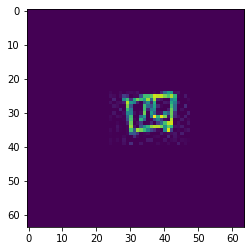

In [46]:
plt.imshow(images[1,:,:])
print(dictt[output[1,:].argmax().item()])

五
